In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
import os
import torchvision.transforms as transforms
from pipnet.pipnet import PIPNet, get_network
from util.data import get_dataloaders
from util.vis_pipnet import get_img_coordinates
from util.func import get_patch_size
from util.eval_cub_csv import get_topk_cub
from PIL import ImageFont, Image, ImageDraw as D

print(torch.cuda.is_available())

!which python

True
/home/harishbabu/.conda/envs/hpnet1/bin/python


In [11]:
run_path = '/home/harishbabu/projects/PIPNet/runs/pipnet_cub_cnext26'

device = torch.device('cuda')
device_ids = [torch.cuda.current_device()]

# device = torch.device('cpu')
# device_ids = []

args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

ckpt_path = os.path.join(run_path, 'checkpoints', 'net_trained_last')
checkpoint = torch.load(ckpt_path, map_location=device)

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)
if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

# Create a convolutional network based on arguments and add 1x1 conv layer
feature_net, add_on_layers, pool_layer, classification_layer, num_prototypes = get_network(len(classes), args)
   
# Create a PIP-Net
net = PIPNet(num_classes=len(classes),
                num_prototypes=num_prototypes,
                feature_net = feature_net,
                args = args,
                add_on_layers = add_on_layers,
                pool_layer = pool_layer,
                classification_layer = classification_layer
                )
net = net.to(device=device)
net = nn.DataParallel(net)    
net.load_state_dict(checkpoint['model_state_dict'],strict=True)

Num classes (k) =  200 ['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet'] etc.
Number of prototypes:  768


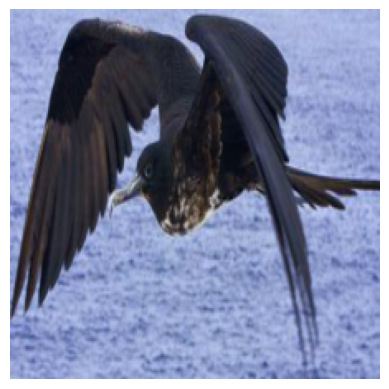

In [84]:
import matplotlib.pyplot as plt

image_tensor, ys1 = trainloader_normal.dataset[1300] # 512, 1024, 1200
image_tensor = image_tensor.to(device)

def show_image(image_np):
    
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    # Visualize the image
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

image_np = image_tensor.numpy()
image_np = image_np.transpose(1, 2, 0)
show_image(image_np)

In [85]:
net.eval()
with torch.no_grad():
    proto_features, pooled, out = net(image_tensor.unsqueeze(0), inference=True) 
    wshape = proto_features.shape[-1]
    args.wshape = wshape #needed for calculating image patch size
    
# all_acts = []
# classification_weights = net.module._classification.weight
# for i in range(proto_features.shape[1]):
#     c_weight = torch.max(classification_weights[:,i])
#     if c_weight > 1e-3:
#         all_acts.append((i, proto_features[0, i].max().item()))
# sorted_acts = sorted(all_acts, key=lambda x: x[1], reverse=True)
# print(sorted_acts[0:10])

proto_acts = {}
classification_weights = net.module._classification.weight
for i in range(proto_features.shape[1]):
    c_weight = torch.max(classification_weights[:,i])
    if c_weight > 1e-3:
        proto_acts[i] = proto_features[0, i].max().item()
        
sorted_proto_acts = sorted([(p, a) for p, a in proto_acts.items()], key=lambda x: x[1], reverse=True)
topk_proto_acts = {p:a for p, a in sorted_proto_acts[0:10]}
# sorted_acts = sorted(all_acts, key=lambda x: x[1], reverse=True)
print('top k activated prototypes\n', topk_proto_acts)

top k activated prototypes
 {363: 0.9999878406524658, 39: 0.9997839331626892, 153: 0.998490571975708, 118: 0.8418290615081787, 740: 0.18634679913520813, 259: 0.07677159458398819, 95: 0.07426571846008301, 275: 0.06790892779827118, 478: 0.06737025082111359, 305: 0.05974990874528885}


/tmp/ipykernel_195503/763302790.py:45: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(label, font=font)
/tmp/ipykernel_195503/763302790.py:45: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(label, font=font)
/tmp/ipykernel_195503/763302790.py:45: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(label, font=font)
/tmp/ipykernel_195503/763302790.py:45: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(label, font=font)


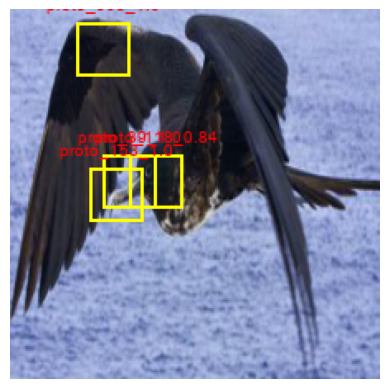

In [86]:
# xs, ys = image_tensor, ys1
patchsize, skip = get_patch_size(args)

image_np = image_tensor.numpy()
image_np = np.transpose(image_np, (1, 2, 0))
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
image_np = (image_np * 255).astype(np.uint8)
image = Image.fromarray(image_np)   
draw = D.Draw(image)

# Use the model to classify this batch of input data
net.eval()
classification_weights = net.module._classification.weight

prototype_image_coords = []

with torch.no_grad():
    softmaxes, _, out = net(image_tensor.unsqueeze(0), inference=True) 

    max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
    # In PyTorch, images are represented as [channels, height, width]
    max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
    max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1)
    for p in range(0, net.module._num_prototypes):
        c_weight = torch.max(classification_weights[:,p]) #ignore prototypes that are not relevant to any class
        if c_weight>1e-3:
            h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
            w_idx = max_idx_per_prototype_w[p]
            idx_to_select = max_idx_per_prototype[p,h_idx, w_idx].item()
            found_max = max_per_prototype[p,h_idx, w_idx].item()

            
            if found_max > 0.5: # prev > 0.5
#             if p == 386: # prev > 0.5
                                    
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)
                
                
                box = (w_coor_min,h_coor_min, w_coor_max, h_coor_max)
                
                prototype_image_coords.append((p, box))

                font = ImageFont.truetype("arial.ttf", 10)
                label = "_".join(["proto", str(p), str(round(found_max, 2))])
                text_width, text_height = draw.textsize(label, font=font)

                text_x = box[0] + (box[2] - box[0]) // 2 - text_width // 2
                text_y = box[1] - text_height - 5

#                 text_x = box[1] - 5
#                 text_y = box[2] - 5

                draw.rectangle(box, outline='yellow', width=2)
                draw.text((text_x, text_y), label, fill="red", font=font)
show_image((np.array(image)))

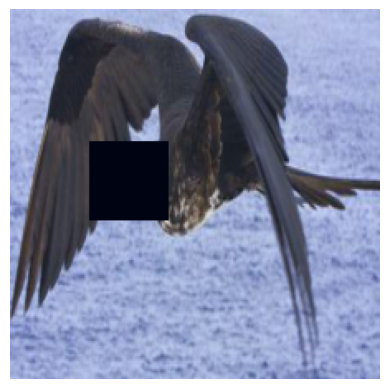

In [97]:
# mask the receptive field

# Define the color of the mask (RGB values)
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
mask_color = (torch.tensor([0, 0, 0], dtype=torch.float32) - mean) / std  # Red color

# mask_color = torch.tensor([0, 0, 0], dtype=torch.float32)  # Red color

# Create a mask of ones in the region
# mask = torch.ones_like(image_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max])
masked_tensor = image_tensor.clone()

for p, box in prototype_image_coords:
    
    if not p in [39]:
        continue
    
    w_coor_min,h_coor_min, w_coor_max, h_coor_max = box

    expand_mask_by = 8

    # Multiply the mask with the desired color
    
    masked_tensor[:, h_coor_min-expand_mask_by:h_coor_max+expand_mask_by, \
                  w_coor_min-expand_mask_by:w_coor_max+expand_mask_by] = mask_color.unsqueeze(1).unsqueeze(1)# * mask

    # Completely mask the entire image
    # masked_tensor = mask_color.unsqueeze(1).unsqueeze(1) * torch.ones_like(image_tensor)

masked_img_np = masked_tensor.numpy()
masked_img_np = masked_img_np.transpose(1, 2, 0)
    
show_image(masked_img_np)


In [98]:
net.eval()
with torch.no_grad():
    proto_features, pooled, out = net(masked_tensor.unsqueeze(0), inference=True) 

# all_acts = []
# for i in range(proto_features.shape[1]):
#     all_acts.append(proto_features[0, i].max().item())
# sorted_acts = sorted([(i, act) for i, act in enumerate(all_acts)], key=lambda x: x[1], reverse=True)
# print(sorted_acts[0:10])

# all_acts_masked = []
# classification_weights = net.module._classification.weight
# for i in range(proto_features.shape[1]):
#     c_weight = torch.max(classification_weights[:,i])
#     if c_weight > 1e-3:
#         all_acts_masked.append((i, proto_features[0, i].max().item()))
# sorted_acts_masked = sorted(all_acts_masked, key=lambda x: x[1], reverse=True)
# print(sorted_acts_masked[0:10])

proto_acts_masked = {}
classification_weights = net.module._classification.weight
for i in range(proto_features.shape[1]):
    c_weight = torch.max(classification_weights[:,i])
    if c_weight > 1e-3:
        proto_acts_masked[i] = proto_features[0, i].max().item()
        
sorted_proto_acts_masked = sorted([(p, a) for p, a in proto_acts_masked.items()], key=lambda x: x[1], reverse=True)
topk_proto_acts_masked = {p:a for p, a in sorted_proto_acts_masked[0:10]}
# sorted_acts = sorted(all_acts, key=lambda x: x[1], reverse=True)
print('top k activated prototypes after masking\n', topk_proto_acts_masked, '\n')

for p, a in topk_proto_acts.items():
    if a > 0.5:
        print(p, 'before', a, 'after', proto_acts_masked[p])

top k activated prototypes after masking
 {363: 0.9999843835830688, 118: 0.722762405872345, 740: 0.18623752892017365, 259: 0.0765996053814888, 95: 0.0743776261806488, 275: 0.06813859194517136, 478: 0.06719519942998886, 305: 0.05955347418785095, 111: 0.05692243576049805, 199: 0.055464308708906174} 

363 before 0.9999878406524658 after 0.9999843835830688
39 before 0.9997839331626892 after 0.007858079858124256
153 before 0.998490571975708 after 0.01679960824549198
118 before 0.8418290615081787 after 0.722762405872345


torch.Size([3, 224, 224])


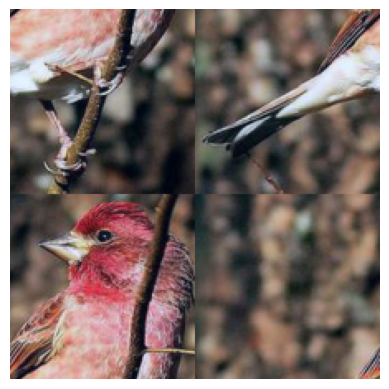

In [94]:
# Permute the four quadrants

height, width = image_tensor.shape[1:]
mid_height = height // 2
mid_width = width // 2

quadrant_1 = image_tensor[:, :mid_height, :mid_width]
quadrant_2 = image_tensor[:, :mid_height, mid_width:]
quadrant_3 = image_tensor[:, mid_height:, :mid_width]
quadrant_4 = image_tensor[:, mid_height:, mid_width:]

# Permute the quadrants
permuted_tensor = torch.cat((torch.cat((quadrant_4, quadrant_3), dim=2), \
                            torch.cat((quadrant_2, quadrant_1), dim=2)), \
                            dim=1)

# The permuted tensor will have shape [3, 224, 224]
print(permuted_tensor.shape)

permuted_img_np = permuted_tensor.numpy()
permuted_img_np = permuted_img_np.transpose(1, 2, 0)
show_image(permuted_img_np)

In [95]:
net.eval()
with torch.no_grad():
    proto_features, pooled, out = net(permuted_tensor.unsqueeze(0), inference=True) 

all_acts = []
for i in range(proto_features.shape[1]):
    all_acts.append(proto_features[0, i].max().item())
sorted_acts = sorted([(i, act) for i, act in enumerate(all_acts)], key=lambda x: x[1], reverse=True)
print(sorted_acts[0:10])

[(533, 1.0), (386, 0.9999974966049194), (159, 0.9997884631156921), (602, 0.9997175335884094), (473, 0.9994606375694275), (172, 0.9986746311187744), (710, 0.9986100196838379), (552, 0.7497818470001221), (227, 0.5791042447090149), (748, 0.5776928663253784)]


/tmp/ipykernel_134846/519505226.py:38: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(label, font=font)


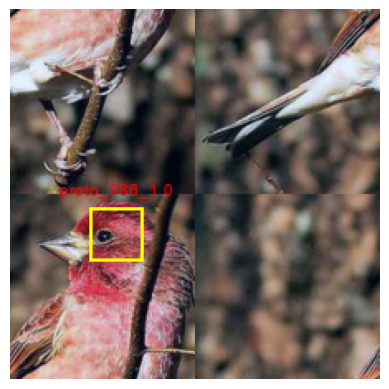

In [97]:
# xs, ys = image_tensor, ys1
patchsize, skip = get_patch_size(args)
image_np = permuted_tensor.numpy()
image_np = np.transpose(image_np, (1, 2, 0))
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
image_np = (image_np * 255).astype(np.uint8)
image = Image.fromarray(image_np)   
draw = D.Draw(image)
# Use the model to classify this batch of input data
net.eval()
classification_weights = net.module._classification.weight
with torch.no_grad():
    softmaxes, _, out = net(permuted_tensor.unsqueeze(0), inference=True) 

    max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
    # In PyTorch, images are represented as [channels, height, width]
    max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
    max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1)
    for p in range(0, net.module._num_prototypes):
        c_weight = torch.max(classification_weights[:,p]) #ignore prototypes that are not relevant to any class
        if c_weight>0:
            h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
            w_idx = max_idx_per_prototype_w[p]
            idx_to_select = max_idx_per_prototype[p,h_idx, w_idx].item()
            found_max = max_per_prototype[p,h_idx, w_idx].item()

            
#             if found_max > 0.99995: # prev > 0.5
            if p == 386: # prev > 0.5
                            
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)
                
                
                box = (w_coor_min,h_coor_min, w_coor_max, h_coor_max)

                font = ImageFont.truetype("arial.ttf", 10)
                label = "_".join(["proto", str(p), str(round(found_max, 2))])
                text_width, text_height = draw.textsize(label, font=font)

                text_x = box[0] + (box[2] - box[0]) // 2 - text_width // 2
                text_y = box[1] - text_height - 5

#                 text_x = box[1] - 5
#                 text_y = box[2] - 5

                draw.rectangle(box, outline='yellow', width=2)
                draw.text((text_x, text_y), label, fill="red", font=font)
show_image((np.array(image)))

In [98]:
k = 10
epoch = 'post_training'
get_topk_cub(net, projectloader, k, epoch, device, args)

Writing CSV file with top k image patches..


'./runs/pipnet_cub_cnext26/post_training_pipnet_prototypes_cub_topk.csv'

In [99]:
df = pd.read_csv('/home/harishbabu/projects/PIPNet/runs/pipnet_cub_cnext26/post_training_pipnet_prototypes_cub_topk.csv')

# def create_new_row(row):
#     new_row = {'class': row['img name'].split('/')[-2].split('.')[0]}
#     return pd.Series(new_row)

# # Apply the function to each row using apply and assign the result to a new row
# new_row = df.apply(lambda row: create_new_row(row), axis=1)

# # Append the new row to the DataFrame
# df = df.append(new_row, ignore_index=False)

def create_new_column(img_name):
    return img_name.split('/')[-2].split('.')[0]

# Apply the function to create a new column using apply
df['class'] = df['img name'].apply(create_new_column)
df.head()

,prototype,img name,h_min_224,h_max_224,w_min_224,w_max_224,scores,class
0,0,/home/harishbabu/data/CUB_200_2011/dataset/tra...,36,68,108,140,0.999997,107
1,0,/home/harishbabu/data/CUB_200_2011/dataset/tra...,20,52,52,84,0.999994,107
2,0,/home/harishbabu/data/CUB_200_2011/dataset/tra...,28,60,132,164,0.999992,029
3,0,/home/harishbabu/data/CUB_200_2011/dataset/tra...,36,68,60,92,0.999989,029
4,0,/home/harishbabu/data/CUB_200_2011/dataset/tra...,4,36,140,172,0.999966,108


In [100]:
df.to_csv('/home/harishbabu/projects/PIPNet/runs/pipnet_cub_cnext26/post_training_pipnet_prototypes_cub_topk_with_class.csv')

# Something to understand convnext architecture

In [7]:
net.module._net

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [1]:
# from features.resnet_features import resnet18_features, resnet34_features, resnet50_features, resnet50_features_inat, resnet101_features, resnet152_features
# from features.convnext_features import convnext_tiny_26_features, convnext_tiny_13_features 

from torchvision import models
model = models.convnext_tiny(pretrained=False, weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

# Something to understand class relevant prototypes

In [3]:
classification_weights = net.module._classification.weight
classification_weights.shape

torch.Size([200, 768])

In [4]:
for c in range(net.module._classification.weight.shape[0]):
        relevant_ps = []
        proto_weights = net.module._classification.weight[c,:]
        for p in range(net.module._classification.weight.shape[1]):
            if proto_weights[p]> 1e-3:
                relevant_ps.append((p, proto_weights[p].item()))
#             print("Class", c, "(", list(testloader.dataset.class_to_idx.keys())[list(testloader.dataset.class_to_idx.values()).index(c)],"):","has", len(relevant_ps),"relevant prototypes: ", relevant_ps, flush=True)
        print(c, '\t', relevant_ps)

0 	 [(301, 13.915472030639648), (402, 3.7949435710906982), (414, 12.143534660339355), (722, 4.372524261474609)]
1 	 [(11, 6.6890153884887695), (156, 2.9370946884155273), (464, 6.762500286102295), (624, 16.091012954711914), (722, 3.960728645324707)]
2 	 [(40, 2.0189969539642334), (337, 7.442060470581055), (402, 0.776678204536438), (538, 16.83687400817871), (643, 12.428648948669434)]
3 	 [(73, 9.764178276062012), (369, 3.0208375453948975), (461, 7.389441967010498), (594, 5.255075454711914), (617, 5.370088577270508), (647, 3.7410354614257812)]
4 	 [(292, 10.299483299255371), (388, 8.186297416687012), (426, 5.520123481750488), (450, 4.379806041717529), (636, 2.9855949878692627), (759, 6.136051654815674)]
5 	 [(32, 5.386838436126709), (231, 21.310428619384766), (373, 3.1141467094421387), (609, 6.427789688110352)]
6 	 [(83, 5.035795211791992), (107, 17.359790802001953), (193, 2.6335771083831787), (373, 3.8684003353118896), (382, 1.2550572156906128), (495, 2.9925434589385986), (715, 4.4082221

72 	 [(23, 4.77023983001709), (339, 0.3121485710144043), (657, 20.428897857666016), (695, 9.382988929748535), (720, 3.9198789596557617)]
73 	 [(67, 8.004837989807129), (376, 10.340524673461914), (536, 8.007835388183594), (695, 9.366907119750977)]
74 	 [(89, 3.082684278488159), (97, 10.104816436767578), (201, 6.730906963348389), (411, 7.050616264343262), (467, 5.510961055755615), (642, 6.170596122741699)]
75 	 [(141, 3.408982038497925), (281, 14.533557891845703), (304, 4.194746017456055), (656, 9.421852111816406)]
76 	 [(55, 1.6274290084838867), (92, 6.999876022338867), (120, 1.1253288984298706), (545, 5.341424942016602), (556, 11.106240272521973), (700, 11.391188621520996)]
77 	 [(120, 2.3459770679473877), (243, 0.7190903425216675), (465, 3.5163631439208984), (545, 3.4826653003692627), (585, 22.564380645751953)]
78 	 [(79, 4.66708517074585), (179, 4.049309253692627), (181, 9.124995231628418), (478, 19.2191162109375)]
79 	 [(71, 9.725471496582031), (255, 3.9119787216186523), (286, 15.07

135 	 [(124, 9.554850578308105), (154, 9.104188919067383), (516, 6.545535087585449), (639, 9.952235221862793)]
136 	 [(304, 0.6697699427604675), (310, 7.474222660064697), (351, 8.759513854980469), (448, 5.013156890869141), (491, 1.7425225973129272), (516, 9.143440246582031)]
137 	 [(304, 3.2563345432281494), (316, 6.258272171020508), (452, 7.056289196014404), (467, 8.227995872497559), (571, 6.696770668029785)]
138 	 [(150, 7.197015762329102), (210, 3.66810941696167), (282, 8.912881851196289), (284, 8.336319923400879), (535, 9.88888168334961), (651, 1.6313283443450928)]
139 	 [(106, 3.879577398300171), (150, 13.315159797668457), (232, 9.399081230163574), (288, 5.431046009063721)]
140 	 [(44, 2.7278389930725098), (89, 7.950915336608887), (395, 5.051093101501465), (515, 11.253153800964355)]
141 	 [(94, 3.778339385986328), (300, 3.017566680908203), (407, 17.01760482788086), (613, 8.910078048706055)]
142 	 [(44, 2.279311418533325), (94, 0.4462709426879883), (188, 12.471278190612793), (422, 

198 	 [(228, 6.683502197265625), (275, 4.537045001983643), (517, 4.474285125732422), (527, 6.199875354766846), (612, 4.146462917327881), (631, 10.075716018676758)]
199 	 [(89, 5.554402828216553), (175, 5.7029500007629395), (573, 11.457196235656738), (689, 9.17813491821289)]


In [6]:
for p in range(net.module._classification.weight.shape[1]):
    relevant_classes = []
    proto_weights = net.module._classification.weight[:,p]
    for c in range(net.module._classification.weight.shape[0]):
        if proto_weights[c]> 1e-3:
            relevant_classes.append((c, proto_weights[c].item()))
    if relevant_classes:
        print(p, '\t', relevant_classes)

0 	 [(26, 0.4552654027938843), (107, 0.06196451559662819)]
3 	 [(82, 6.580137729644775), (144, 5.859857559204102)]
5 	 [(60, 16.109905242919922)]
6 	 [(63, 3.4854700565338135), (65, 9.473688125610352)]
8 	 [(8, 4.023455619812012), (29, 6.190260887145996)]
9 	 [(159, 4.106473445892334)]
10 	 [(39, 5.247584342956543)]
11 	 [(1, 6.6890153884887695), (89, 6.96606969833374)]
12 	 [(178, 15.171945571899414)]
15 	 [(13, 7.626095771789551), (94, 4.7954864501953125), (119, 4.982254981994629)]
16 	 [(169, 7.062816619873047), (192, 7.492598056793213)]
17 	 [(86, 5.258004188537598)]
18 	 [(101, 6.8381781578063965), (102, 5.045945644378662)]
20 	 [(146, 9.237372398376465)]
21 	 [(114, 6.538973331451416), (118, 8.266152381896973)]
22 	 [(114, 8.326904296875), (120, 8.332756042480469)]
23 	 [(72, 4.77023983001709), (90, 4.0476298332214355), (129, 6.5248284339904785)]
24 	 [(119, 3.863232135772705), (124, 4.292637825012207), (171, 4.886501789093018), (195, 4.577577590942383)]
25 	 [(24, 16.53002166748

225 	 [(19, 6.131804466247559), (94, 3.4134762287139893), (95, 4.096406936645508), (161, 6.179423809051514)]
228 	 [(97, 1.1800565719604492), (182, 9.36280632019043), (198, 6.683502197265625)]
231 	 [(5, 21.310428619384766)]
232 	 [(55, 9.885818481445312), (139, 9.399081230163574)]
233 	 [(31, 2.297657012939453), (32, 4.4446282386779785)]
235 	 [(92, 26.060577392578125)]
237 	 [(57, 5.5258989334106445), (88, 7.233149528503418)]
238 	 [(62, 4.267422676086426), (83, 3.364910125732422)]
243 	 [(77, 0.7190903425216675)]
246 	 [(16, 5.749167442321777), (41, 1.754769206047058), (115, 7.226898193359375)]
247 	 [(68, 6.748265743255615)]
248 	 [(189, 16.304351806640625)]
251 	 [(27, 9.236141204833984), (191, 8.548124313354492)]
255 	 [(79, 3.9119787216186523), (82, 8.424259185791016)]
256 	 [(92, 0.176534503698349), (197, 1.3815721273422241)]
259 	 [(91, 10.03634262084961)]
260 	 [(132, 19.796110153198242)]
262 	 [(15, 8.357916831970215), (171, 10.368491172790527)]
264 	 [(23, 9.129125595092773

484 	 [(144, 20.388683319091797)]
485 	 [(134, 13.23537540435791)]
487 	 [(45, 2.7226505279541016), (80, 2.6344239711761475), (88, 5.454470634460449)]
488 	 [(132, 6.7375688552856445), (164, 8.052359580993652)]
490 	 [(155, 3.1184732913970947), (163, 3.680532932281494), (164, 3.2828404903411865), (181, 5.552408218383789)]
491 	 [(11, 6.380468845367432), (68, 5.400190353393555), (136, 1.7425225973129272)]
492 	 [(99, 1.6510794162750244)]
494 	 [(59, 9.758462905883789), (63, 2.6747031211853027)]
495 	 [(6, 2.9925434589385986), (23, 3.4301950931549072), (57, 3.6631264686584473)]
496 	 [(160, 9.111358642578125), (164, 3.8139994144439697), (165, 5.080450057983398)]
502 	 [(87, 4.916020393371582), (109, 3.450618028640747), (193, 7.755481719970703)]
503 	 [(22, 3.291029930114746), (24, 3.481165885925293)]
504 	 [(162, 11.252623558044434), (176, 12.704256057739258)]
507 	 [(71, 15.27466869354248)]
509 	 [(197, 12.98349380493164)]
513 	 [(103, 3.1862926483154297), (123, 5.394778728485107), (179

715 	 [(6, 4.408222198486328), (99, 7.299081325531006)]
717 	 [(40, 27.68134880065918)]
719 	 [(97, 20.46845054626465)]
720 	 [(72, 3.9198789596557617), (121, 5.94895601272583), (125, 4.0865068435668945)]
721 	 [(117, 15.026411056518555)]
722 	 [(0, 4.372524261474609), (1, 3.960728645324707), (93, 5.34586763381958)]
723 	 [(7, 12.782931327819824)]
726 	 [(18, 10.292729377746582), (93, 10.332283020019531)]
727 	 [(62, 13.26205062866211)]
731 	 [(112, 13.547208786010742)]
732 	 [(61, 5.071514129638672), (63, 1.2226154804229736), (64, 5.585809230804443)]
735 	 [(182, 4.575986862182617), (183, 4.955862045288086), (192, 4.733166217803955)]
736 	 [(81, 10.408897399902344)]
737 	 [(155, 0.5443680286407471), (156, 5.546560764312744), (161, 4.677530288696289), (167, 6.223366737365723)]
738 	 [(49, 4.385389804840088), (127, 8.209434509277344), (147, 2.7451701164245605)]
739 	 [(129, 13.733386993408203)]
740 	 [(142, 4.9132184982299805)]
741 	 [(47, 9.064698219299316), (184, 11.157814979553223)]


In [12]:
net.module._classification.normalization_multiplier

Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)